# Act Log Analysis

In [1]:
# imports
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy
from skimage import filters
from skimage import data
import seaborn as sns
from collections import Counter
import copy
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

In [2]:
# print and show what the entire dict looks like
def inspect_dict(d, level=0):
    """
    Recursively inspect a dictionary to determine its structure.
    
    Parameters:
    - d: Dictionary to inspect.
    - level: Current depth level (for nested dictionaries).
    """
    for key, value in d.items():
        indent = "  " * level  # Indentation for better readability
        if isinstance(value, dict):
            print(f"{indent}{key}: (Nested dictionary)")
            inspect_dict(value, level + 1)
        else:
            print(f"{indent}{key}: {type(value).__name__} (Value: {value})")

In [3]:
# Define the file paths
files = [
    '../../topk/base_auxt.pkl',
    '../../topk/base_hsm.pkl',
    '../../topk/base_hsm1.pkl',
    '../../topk/base_hsp.pkl',
    '../../topk/base_maths.pkl',
    '../../topk/base_physics.pkl',
    '../../topk/base_philosophy.pkl',
] 

# Load all files into a single dict
topk = {}

for file_path in files:
    with open(file_path, 'rb') as f:
        topk[file_path] = pickle.load(f)

In [4]:
hsm1 = topk['../../topk/base_hsm1.pkl']

# print first key in hsm1
print(hsm1.keys())
print(len(hsm1['model.layers.0.mlp.gate_proj']['values']))

# get the number of all of the values stored in hsm1


dict_keys(['model.layers.0.mlp.gate_proj', 'model.layers.0.mlp.act_fn', 'model.layers.0.mlp.up_proj', 'model.layers.0.mlp.down_proj', 'model.layers.1.mlp.gate_proj', 'model.layers.1.mlp.act_fn', 'model.layers.1.mlp.up_proj', 'model.layers.1.mlp.down_proj', 'model.layers.2.mlp.gate_proj', 'model.layers.2.mlp.act_fn', 'model.layers.2.mlp.up_proj', 'model.layers.2.mlp.down_proj', 'model.layers.3.mlp.gate_proj', 'model.layers.3.mlp.act_fn', 'model.layers.3.mlp.up_proj', 'model.layers.3.mlp.down_proj', 'model.layers.4.mlp.gate_proj', 'model.layers.4.mlp.act_fn', 'model.layers.4.mlp.up_proj', 'model.layers.4.mlp.down_proj', 'model.layers.5.mlp.gate_proj', 'model.layers.5.mlp.act_fn', 'model.layers.5.mlp.up_proj', 'model.layers.5.mlp.down_proj', 'model.layers.6.mlp.gate_proj', 'model.layers.6.mlp.act_fn', 'model.layers.6.mlp.up_proj', 'model.layers.6.mlp.down_proj', 'model.layers.7.mlp.gate_proj', 'model.layers.7.mlp.act_fn', 'model.layers.7.mlp.up_proj', 'model.layers.7.mlp.down_proj', 'mode

In [5]:
# step 1: show hsm1 for topk of 3,100, and 1000
# show all the nodes activated per layer as a graph

# get the topk_act
def get_act_index(d,topk, mink = 0):
    act_index = []
    for layer_name, values in d.items():
        # removing down just because it has 4000 nodes per layer unlike the rest
        if "down" not in layer_name:
            for name, val in values.items():
                if name == "indices":
                    act_index.append(val[mink:topk])
    return act_index


# get the topk_act values
def get_act_values(d,topk, mink = 50):
    act_index = []
    for layer_name, values in d.items():
        # removing down just because it has 4000 nodes per layer unlike the rest
        # if "down" not in layer_name:
        for name, val in values.items():
            if name == "values":
                act_index.append(val[mink:topk])
    return act_index

# print the graph for the items
# need to make a heat color based on the order of it
def show_act_in_layers(data,color):
    for row_index, row in enumerate(data):
        x_values = [row_index] * len(row)  # X-axis is the row index
        y_values = row  # Y-axis is the row values
        plt.scatter(
            x_values, 
            y_values, 
            marker='.', 
            s=20, 
            color=color,
            label=f"Row {row_index}"
        )
    

In [6]:
mink = 0

# load all the topk values
maths = topk['../../topk/base_maths.pkl']
act_index_maths = get_act_index(maths,1000, mink = mink)
act_values_maths = get_act_values(maths,1000, mink = mink)

physics = topk['../../topk/base_physics.pkl']
act_index_physics = get_act_index(physics,1000, mink = mink)
act_values_physics = get_act_values(physics,1000, mink = mink)

philosophy = topk['../../topk/base_philosophy.pkl']
act_index_philosophy = get_act_index(philosophy,1000, mink = mink)
act_values_philosophy = get_act_values(philosophy,1000, mink = mink)

auxt = topk['../../topk/base_auxt.pkl']
act_index_auxt = get_act_index(auxt,1000, mink = mink)
act_values_auxt = get_act_values(auxt,1000, mink = mink)

In [7]:
print (act_values_maths[0][0:10])

# [1.3037109375, 1.2802734375, 1.271484375, 1.2666015625, 1.25390625, 1.25390625, 1.2470703125, 1.244140625, 1.23828125, 1.236328125] 1 iter
# [3.08984375, 3.0546875, 3.03125, 3.02734375, 3.001953125, 2.994140625, 2.931640625, 2.9140625, 2.87109375, 2.865234375] 10 iter

[8191.97119140625, 8191.9228515625, 8184.29638671875, 8148.8984375, 8135.3955078125, 8129.14990234375, 8114.1875, 8112.28857421875, 8110.17041015625, 8108.97265625]


In [8]:
# check the the quality of the observations
flattened_list = [item for sublist in act_values_maths for item in sublist]

# Find the maximum value
max_value = max(flattened_list)
min_value = min(flattened_list)


# Count how many times the maximum value appears
count_max = flattened_list.count(max_value)
count_min = flattened_list.count(min_value)

print(f"The maximum value is {max_value} and it appears {count_max} times out of {len(flattened_list)}, ({100*count_max/len(flattened_list)}%)")
print(f"The minimum value is {min_value} and it appears {count_min} times out of {len(flattened_list)}, ({100*count_min/len(flattened_list)}%)")

# 0.00078125%

The maximum value is 8191.97607421875 and it appears 617 times out of 128000, (0.48203125%)
The minimum value is 4095.988037109375 and it appears 740 times out of 128000, (0.578125%)


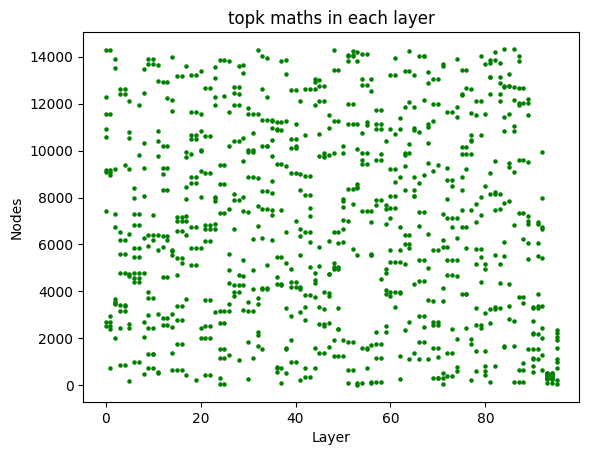

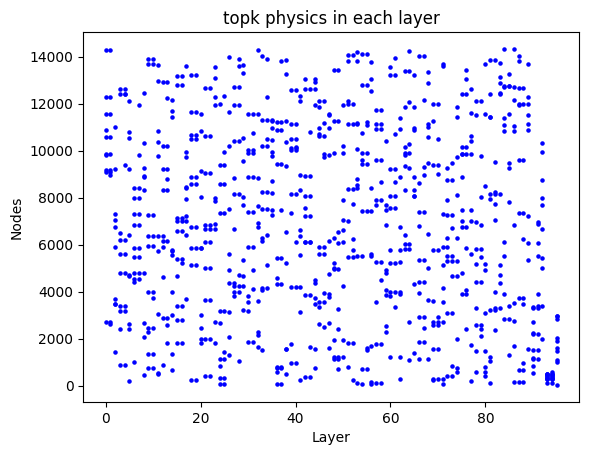

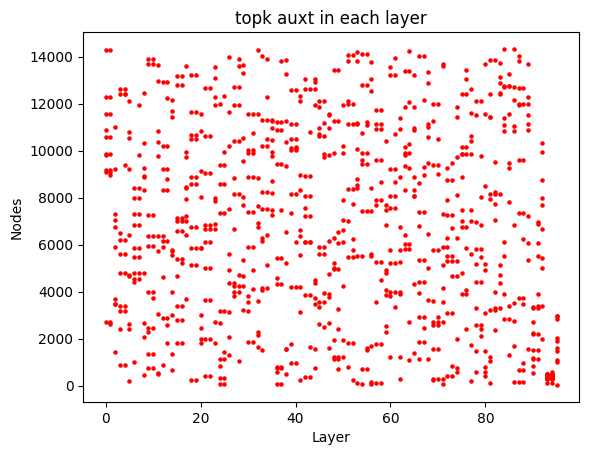

In [9]:
mk = 0
k = 10

act_index_mathsk = get_act_index(maths,k, mink = mk)
act_index_physicsk = get_act_index(physics,k, mink = mk)
act_index_auxtk = get_act_index(physics,k, mink = mk)

show_act_in_layers(act_index_mathsk,"green")
plt.xlabel("Layer")
plt.ylabel("Nodes")
plt.title("topk maths in each layer")
plt.show()


show_act_in_layers(act_index_physicsk,"blue")
plt.xlabel("Layer")
plt.ylabel("Nodes")
plt.title("topk physics in each layer")
plt.show()


show_act_in_layers(act_index_auxtk,"red")
plt.xlabel("Layer")
plt.ylabel("Nodes")
plt.title("topk auxt in each layer")
plt.show()

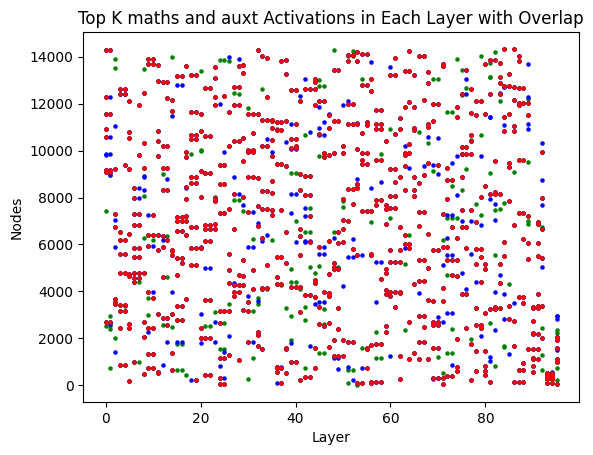

In [10]:
# Plot maths activations
show_act_in_layers(act_index_mathsk, "green")
# Plot auxt activations
show_act_in_layers(act_index_auxtk, "blue")

# Calculate the overlap (intersection) between the two sets of node positions
overlap = []
for layer in range(len(act_index_mathsk)):
    # Find common nodes between maths and auxt for this layer
    common_nodes = set(act_index_mathsk[layer]).intersection(set(act_index_auxtk[layer]))
    overlap.append(list(common_nodes))

# Plot the overlap
show_act_in_layers(overlap, "red")

plt.xlabel("Layer")
plt.ylabel("Nodes")
plt.title("Top K maths and auxt Activations in Each Layer with Overlap")
plt.show()

realised the up proj max for topk is 4000 and therefore is a much more dense layer, but for the rest of them, they all go up to 14k. May want to either play with that or turn it off in the future

In [11]:
# showing it as a heat image where the order dictates the heat of it per layer

def topk_act_to_img(data, data_name):
    data = np.array(data)
    struct_data = np.zeros((len(data), np.max(data)+1))
    
    # change list struct
    for i, ival in enumerate(data):
        for j, jval in enumerate(ival):
            struct_data[i][jval] = len(ival) -  int(j)

    # generate the image
    plt.figure(dpi = 200)
    plt.imshow(struct_data.T, vmin=50, vmax=255, aspect = 0.006, cmap = "viridis")
    plt.xlabel("Layer")
    plt.ylabel("Node index")
    plt.title("Top-k in each layer for {}".format(data_name))
    plt.show()

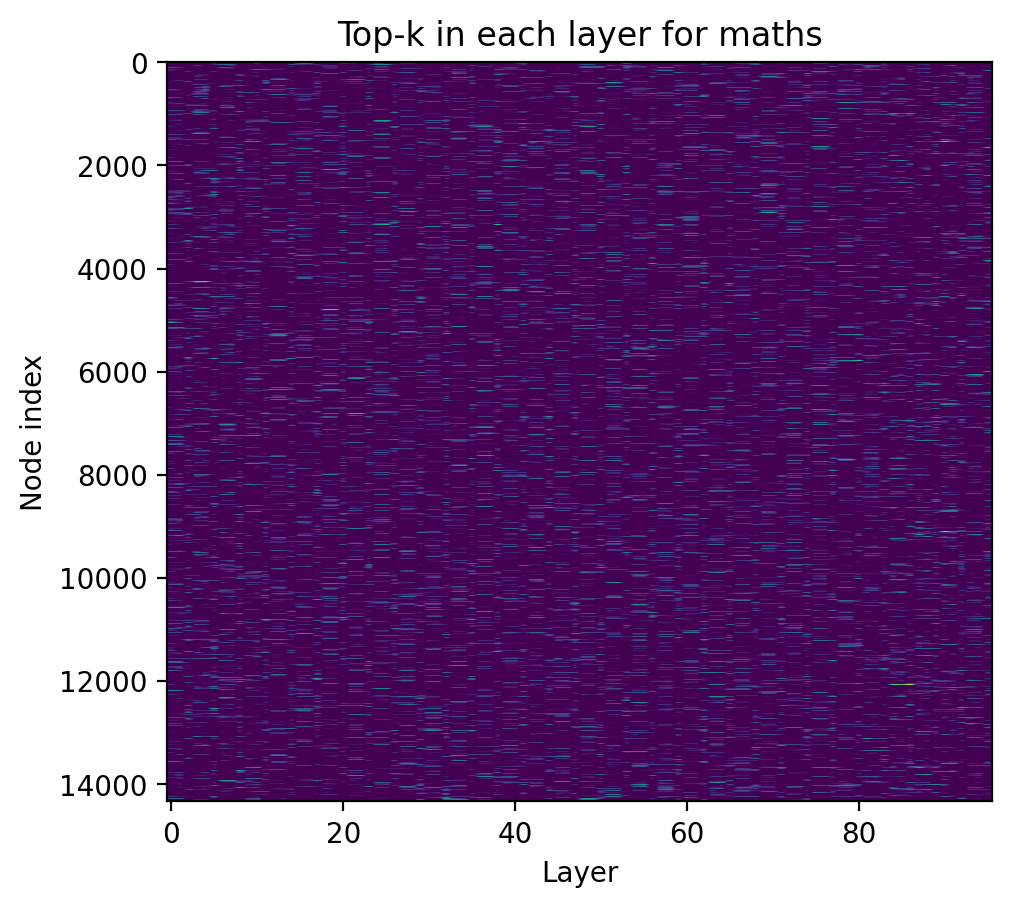

In [12]:
# always seeing a pitchfork, but it's literally my mind making that up
topk_act_to_img(act_index_maths, "maths")

In [13]:
# step 2: show the difference between hsm and hsm1
# show the deviation amount in scores between the 2

# showing the percentage change
def compare_act_logs(d1,d2,topk:int):
    total_matched = 0
    total = 0

    for i in range(len(d1)):
        for j in range(topk):
            total += 1
            if d2[i][j] != None:
                if d2[i][j] in d1[i][:topk]:    
                    total_matched += 1

    print ("total topk values: ", total)
    print ("total topk matched: ", total_matched)
    print ("percentage of topk matched: ", total_matched/total * 100,"%")

    return total_matched/total * 100


def subtract_act_logs(d1,d2):
    total = len(d1) * len(d1[0])
    print ("original total: ", total)

    d3 = copy.deepcopy(d1)
    
    total_subtracted = 0
    for i in range(len(d2)):
        for j in range(1000):
            if d1[i][j] in d2[i]:    
                d3[i][j] = None
                total_subtracted += 1

    print ("amount subtracted: ", total_subtracted)

    return d3

In [14]:
# step 3: show the topk of hsm and compare that to auxt and rand
# essentially showing that the activations are different to just random ones

# generate a random rand index
def gen_rand_act_index(data):
    row = len(data)
    col = len(data[0])

    max_val = max(map(max,data))

    print("max value: ",max_val)
    rand_data = np.random.randint(max_val,size = (row,col))

    return rand_data

# less entropy means that the data is less likely to be random (relative)
def rand_check(data, base_data):
    data = np.array(data)
    value_counts = np.bincount(data.flatten())
    entropy_value = scipy.stats.entropy(value_counts, base=2)
    
    base_data = np.array(base_data)
    base_value_counts = np.bincount(base_data.flatten())
    base_entropy_value = scipy.stats.entropy(base_value_counts, base=2)

    print(f"Entropy: {entropy_value}")
    print(f"Entropy relative to the base: {entropy_value/base_entropy_value}")

    return None

In [15]:
act_index_maths_sub_auxt = subtract_act_logs(act_index_maths, act_index_auxt)
act_index_physics_sub_auxt = subtract_act_logs(act_index_physics, act_index_auxt)
act_index_philosophy_sub_auxt = subtract_act_logs(act_index_philosophy, act_index_auxt)


act_index_rand = gen_rand_act_index(act_index_auxt)


k = 100

print("\n maths sub and physics sub")
compare_act_logs(act_index_maths_sub_auxt,act_index_physics_sub_auxt,k)
print("\n maths sub and philosophy sub")
compare_act_logs(act_index_maths_sub_auxt,act_index_philosophy_sub_auxt,k)
print("\n physics sub and philosophy sub")
compare_act_logs(act_index_physics_sub_auxt,act_index_philosophy_sub_auxt,k)
print("\n maths and physics")
compare_act_logs(act_index_physics, act_index_maths, k)
print("\n maths and philosophy")
compare_act_logs(act_index_philosophy, act_index_maths, k)
print("\n physics and philosophy")
compare_act_logs(act_index_philosophy, act_index_physics, k)
print("\n maths and auxt")
compare_act_logs(act_index_maths, act_index_auxt, k)
print("\n physics and auxt")
compare_act_logs(act_index_physics, act_index_auxt, k)
print("\n philosophy and auxt")
compare_act_logs(act_index_philosophy, act_index_auxt, k)


# random checks
print("\n")
print("\n")
compare_act_logs(act_index_maths, act_index_rand, k)
print("\n")
compare_act_logs(act_index_physics, act_index_rand, k)
print("\n")
compare_act_logs(act_index_philosophy, act_index_rand, k)
print("\n")
compare_act_logs(act_index_auxt, act_index_rand, k)

original total:  96000
amount subtracted:  44462
original total:  96000
amount subtracted:  47004
original total:  96000
amount subtracted:  44806
max value:  14335

 maths sub and physics sub
total topk values:  9600
total topk matched:  1467
percentage of topk matched:  15.281249999999998 %

 maths sub and philosophy sub
total topk values:  9600
total topk matched:  1425
percentage of topk matched:  14.84375 %

 physics sub and philosophy sub
total topk values:  9600
total topk matched:  1374
percentage of topk matched:  14.3125 %

 maths and physics
total topk values:  9600
total topk matched:  7594
percentage of topk matched:  79.10416666666666 %

 maths and philosophy
total topk values:  9600
total topk matched:  7509
percentage of topk matched:  78.21875 %

 physics and philosophy
total topk values:  9600
total topk matched:  7547
percentage of topk matched:  78.61458333333333 %

 maths and auxt
total topk values:  9600
total topk matched:  4775
percentage of topk matched:  49.73

0.6458333333333334

In [16]:
# plot line graph of correlation between math sub and physics sub from k = 1 to 1000

def get_correlation(d1,d2):
    corr = []
    for k in range(1,1001):
        corr.append(compare_act_logs(d1,d2,k))
    return corr

def plot_correlation(corr):
    x = np.arange(1,1001)
    y = corr
    plt.plot(x,y)
    plt.xlabel("Top-k")
    plt.ylabel("Percentage of top-k matched")
    plt.show()

In [17]:
corr = get_correlation(act_index_maths_sub_auxt, act_index_physics_sub_auxt)


total topk values:  96
total topk matched:  0
percentage of topk matched:  0.0 %
total topk values:  192
total topk matched:  4
percentage of topk matched:  2.083333333333333 %
total topk values:  288
total topk matched:  5
percentage of topk matched:  1.7361111111111112 %
total topk values:  384
total topk matched:  10
percentage of topk matched:  2.604166666666667 %
total topk values:  480
total topk matched:  14
percentage of topk matched:  2.9166666666666665 %
total topk values:  576
total topk matched:  19
percentage of topk matched:  3.298611111111111 %
total topk values:  672
total topk matched:  20
percentage of topk matched:  2.976190476190476 %
total topk values:  768
total topk matched:  21
percentage of topk matched:  2.734375 %
total topk values:  864
total topk matched:  26
percentage of topk matched:  3.009259259259259 %
total topk values:  960
total topk matched:  33
percentage of topk matched:  3.4375000000000004 %
total topk values:  1056
total topk matched:  42
perce

In [18]:
corr_wo_sub = get_correlation(act_index_maths, act_index_philosophy)

total topk values:  96
total topk matched:  78
percentage of topk matched:  81.25 %
total topk values:  192
total topk matched:  168
percentage of topk matched:  87.5 %
total topk values:  288
total topk matched:  244
percentage of topk matched:  84.72222222222221 %
total topk values:  384
total topk matched:  317
percentage of topk matched:  82.55208333333334 %
total topk values:  480
total topk matched:  394
percentage of topk matched:  82.08333333333333 %
total topk values:  576
total topk matched:  469
percentage of topk matched:  81.42361111111111 %
total topk values:  672
total topk matched:  549
percentage of topk matched:  81.69642857142857 %
total topk values:  768
total topk matched:  615
percentage of topk matched:  80.078125 %
total topk values:  864
total topk matched:  691
percentage of topk matched:  79.97685185185185 %
total topk values:  960
total topk matched:  768
percentage of topk matched:  80.0 %
total topk values:  1056
total topk matched:  837
percentage of topk

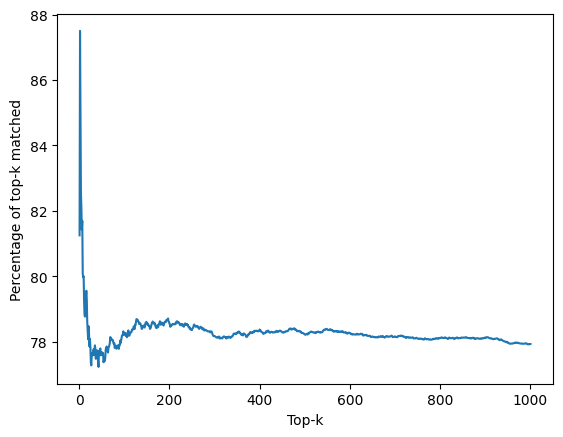

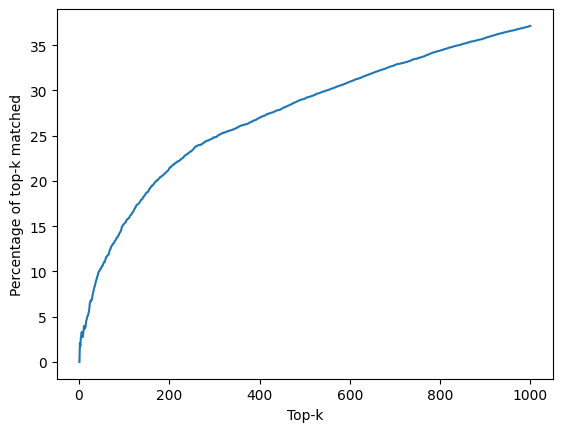

In [20]:
plot_correlation(corr_wo_sub)
plot_correlation(corr)

In [21]:
rand_check(act_index_rand, act_index_auxt)
rand_check(act_index_physics, act_index_auxt)
rand_check(act_index_maths, act_index_auxt)

Entropy: 13.697249972169706
Entropy relative to the base: 1.0039642702675442
Entropy: 13.633166352564606
Entropy relative to the base: 0.9992671475222004
Entropy: 13.634198680956988
Entropy relative to the base: 0.999342813865681


analyse layer activation